<a href="https://colab.research.google.com/github/Mehrab-Shahbazi/K_means-with-desired-size/blob/main/KMeans_desired_size.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**let's clone the repo.**

In [ ]:
!git clone https://github.com/Carriot-Tech/data-scientist-challenge.git

Cloning into 'data-scientist-challenge'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 12 (delta 2), reused 12 (delta 2), pack-reused 0
Receiving objects: 100% (12/12), 76.52 KiB | 4.03 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [ ]:
%cd data-scientist-challenge

/content/data-scientist-challenge


**load data and libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import cm, colors

In [ ]:
points = pd.read_csv("/content/data-scientist-challenge/test.csv")
clusters = np.load("/content/data-scientist-challenge/cluster_sizes.npy")
df = points[["Geo location latitude","Geo location longitude" ]]


In [ ]:
clusters.shape

(30,)

In [ ]:
df.describe()

,Geo location latitude,Geo location longitude
count,903.000000,903.000000
mean,35.565174,53.094833
std,0.101856,0.253029
min,35.235096,52.744374
25%,35.482820,52.884954
50%,35.563071,53.058782
75%,35.651468,53.174050
max,35.811091,53.817212


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903 entries, 0 to 902
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Geo location latitude   903 non-null    float64
 1   Geo location longitude  903 non-null    float64
dtypes: float64(2)
memory usage: 14.2 KB


**visualize data**

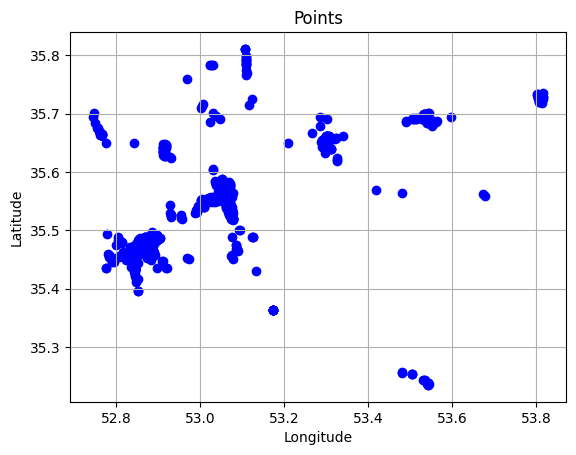

In [ ]:

latitude =  points["Geo location latitude"]
longitude =  points["Geo location longitude"]

plt.scatter(longitude, latitude, color='blue', marker='o')
plt.title('Points')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

In [ ]:
!pip install folium

**lets see it in a map**

In [ ]:
import folium

# Create a folium map centered at an initial location
mymap = folium.Map(location=[df['Geo location latitude'].mean(), df['Geo location longitude'].mean()], zoom_start=4)

# Add markers for each row in the DataFrame
for index, row in df.iterrows():
    folium.Marker(location=[row['Geo location latitude'], row['Geo location longitude']], popup=str(index)).add_to(mymap)

# Display the map
mymap


**Algorithms:**

there are many ways to solve the problem. the main problem is to minimize the size of distance from points to their centers which we can consider it as a eror. this method is much works like K_Means algorithm which is a popular method Machin Learning.

there are many ways to solve the problem but we use **2 algorithm** which have diffrence outputs.

**first algorithm:**

in this algorithm we assign points to centers untill the size of centers be full.

In [ ]:
print(np.newaxis)

None


In [ ]:
class KMeansByGroup:
    def __init__(self, clusters):
        self.num_centers = len(clusters)
        self.initial_centroids = None
        self.num_members_per_center = None
        self.max_iterations = None
        self.final_centroids = None
        self.final_assignments = None

    def assign_points_to_centers(self, data, centroids, num_members):
        num_points = data.shape[0]
        num_centers = centroids.shape[0]
        # Compute distance matrix between all points and all centers
        distances = np.linalg.norm(data.values[:, np.newaxis, :] - centroids, axis=2)
        # distances = distances**2
        # Initialize a list to store assigned points and their corresponding center indices
        assigned_points = []
        # Assign points to centers based on the specified number of members
        for k in range(num_centers):

            # Get the indices of the k nearest points to the current center
            center_distances = distances[:, k]
            sorted_indices = np.argsort(center_distances)
            # Select the first k points that have not been assigned yet
            selected_indices = sorted_indices[:num_members[k]]
            # Store the assigned points and their center index
            assigned_points.extend([(point_index, k) for point_index in selected_indices])
            # Update distances by setting distances of assigned points to infinity
            distances[selected_indices, :] = np.inf

        return np.array(assigned_points)

    def update_centroids(self, data, old_centroids, assignments):
        K = old_centroids.shape[0]
        centroids = []

        for k in range(K):
            # collect indices of points belonging to kth cluster
            S_k = np.argwhere(assignments[:, 1] == k).flatten()

            # take average of points belonging to this cluster
            if len(S_k) > 0:
                c_k = np.mean(data.iloc[S_k, :].values, axis=0)
            else:  # what if no points in the cluster? keep the previous centroid
                c_k = np.copy(old_centroids[k, :])
            centroids.append(c_k)

        return np.array(centroids)

    def my_kmeans(self, data, centroids, max_its, num_members_per_center):
        # outer loop - alternate between updating assignments / centroids
        for j in range(max_its):

            # update cluster assignments
            assignments = self.assign_points_to_centers(data, centroids, num_members_per_center)
            # update centroid locations
            centroids = self.update_centroids(data, centroids, assignments)

        # final assignment update
        assignments = self.assign_points_to_centers(data, centroids, num_members_per_center)
        return centroids, assignments

    def fit(self, data, clusters, max_iterations):
        self.initial_centroids = np.random.uniform(low=-50, high=50, size=(self.num_centers, 2))
        self.num_members_per_center = clusters
        self.max_iterations = max_iterations

        self.final_centroids, self.final_assignments = self.my_kmeans(
            data, self.initial_centroids, self.max_iterations, self.num_members_per_center
        )

    def get_final_centroids(self):
        return self.final_centroids

    def get_final_assignments(self):
        return self.final_assignments


max_iterations = 10
kmeans = KMeansByGroup(clusters)
kmeans.fit(df, clusters, max_iterations)
final_centroids = kmeans.get_final_centroids()
final_assignments = kmeans.get_final_assignments()

cluster_df = pd.DataFrame(final_assignments, columns=['Index', 'Cluster'])
result_df = cluster_df.groupby('Cluster')['Index'].agg(list).reset_index()
result_df.columns = ['Cluster', 'Indices']

# Display the resulting DataFrame
print(result_df)
print("Final Centroids (latitude, longitude):")
print(final_centroids)
print("Final Assignments:")
print(result_df)



    Cluster                                            Indices
0         0  [10, 2, 30, 6, 22, 23, 100, 9, 5, 17, 8, 18, 2...
1         1  [109, 51, 44, 52, 115, 46, 37, 42, 36, 55, 41,...
2         2  [56, 69, 93, 60, 73, 61, 48, 62, 59, 838, 814,...
3         3  [24, 12, 14, 98, 690, 794, 783, 823, 842, 685,...
4         4  [852, 139, 142, 897, 145, 123, 146, 127, 95, 4...
5         5  [147, 155, 150, 867, 153, 240, 210, 172, 148, ...
6         6  [199, 200, 190, 204, 205, 186, 193, 196, 203, ...
7         7  [239, 257, 249, 233, 245, 238, 242, 236, 243, ...
8         8  [312, 298, 300, 313, 314, 286, 875, 297, 301, ...
9         9  [332, 258, 226, 255, 256, 322, 330, 321, 324, ...
10       10  [534, 493, 412, 873, 244, 230, 229, 224, 282, ...
11       11  [352, 868, 339, 337, 338, 342, 357, 355, 335, ...
12       12  [446, 410, 442, 440, 864, 402, 361, 885, 403, ...
13       13  [372, 480, 450, 408, 464, 471, 465, 525, 894, ...
14       14  [424, 431, 439, 420, 437, 523, 428, 76, 41

**restructuring outout to requested restructuring**

In [ ]:
# mange the output to save in csv as requested
output = result_df
for index, row in output.iterrows():

    indices_list = row['Indices']
    lat_lon_list = []
    for index_val in indices_list:
        lat_val = df.loc[index_val, 'Geo location latitude']
        lon_val = df.loc[index_val, 'Geo location longitude']
        lat_lon_list.append((lat_val, lon_val))
    output.at[index, 'Indices'] = lat_lon_list
output.to_csv('/content/data-scientist-challenge/output1.csv', index=False)
output.head()

,Cluster,Indices
0,0,"[(35.6349756, 52.9151968), (35.6343671, 52.916..."
1,1,"[(35.650014, 52.8422855), (35.6506081, 52.7761..."
2,2,"[(35.5434785, 52.9283666), (35.5301334, 52.928..."
3,3,"[(35.6242741, 52.9309597), (35.6252058, 52.929..."
4,4,"[(35.6902403, 53.047237), (35.6965023, 53.0386..."


**visulize results**

In [ ]:

# Create a new map centered on a specific location
m = folium.Map(location=[0, 0], zoom_start=2)

# Generate a colormap with the number of clusters
num_clusters = len(output)
colormap = cm.get_cmap('tab20', num_clusters)

# Plot each cluster
for i, row in output.iterrows():
    cluster_id = row['Cluster']
    points = row['Indices']

    # Create a feature group for the cluster
    cluster_fg = folium.FeatureGroup(name=f'Cluster {cluster_id}')

    # Generate a color for the cluster
    color = colors.rgb2hex(colormap(cluster_id % num_clusters))

    # Plot each point in the cluster
    for point in points:
        # Extract latitude and longitude
        lat, lon = point

        # Create a marker for the point and add it to the feature group
        folium.CircleMarker(location=[lat, lon], color=color, fill=True, fill_color=color, fill_opacity=0.7).add_to(cluster_fg)

    # Add the feature group to the map
    cluster_fg.add_to(m)

# Add a layer control to the map
folium.LayerControl().add_to(m)
m.save('/content/data-scientist-challenge/cluster_map1.html')
# Display the map
m

<ipython-input-18-53850e76eb62>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('tab20', num_clusters)


In [ ]:
!pip install folium

**second algorithm**

In [ ]:
import folium

In [ ]:
class KMeansByCenter:
    def __init__(self, num_clusters, max_iterations):
        self.num_clusters = num_clusters
        self.max_iterations = max_iterations

    def assign_points_to_clusters(self, centroids, points, cluster_sizes):
        num_clusters = len(centroids)
        num_points = len(points)
        cluster_assignments = [[] for _ in range(num_clusters)]
        assigned_points = set()

        for cluster_idx in range(num_clusters):
            centroid = centroids[cluster_idx]
            cluster_size = cluster_sizes[cluster_idx]

            # Calculate Euclidean distances between centroid and points
            distances = np.linalg.norm(points - centroid, axis=1)
            # distnaces = distances**4
            # Sort distances and get the indices of the nearest points
            nearest_indices = np.argsort(distances)

            # Assign points to the cluster until it reaches the desired size
            assigned_points_cluster = 0
            point_idx = 0
            while assigned_points_cluster < cluster_size and point_idx < num_points:
                point = nearest_indices[point_idx]
                if point not in assigned_points:
                    cluster_assignments[cluster_idx].append(point)
                    assigned_points.add(point)
                    assigned_points_cluster += 1
                point_idx += 1

        total_elements = sum(len(sublist) for sublist in cluster_assignments)

        # Create an empty NumPy array of the required shape
        result = np.zeros((total_elements, 2), dtype=int)

        # Fill the array with the numbers and their corresponding indices
        current_index = 0
        for i, sublist in enumerate(cluster_assignments):
            for num in sublist:
                result[current_index] = [num, i]
                current_index += 1

        return result


    def update_centroids(self, data, old_centroids, assignments):
        K = old_centroids.shape[0]
        centroids = []

        for k in range(K):
            # collect indices of points belonging to kth cluster
            S_k = np.argwhere(assignments[:, 1] == k).flatten()

            # take average of points belonging to this cluster
            if len(S_k) > 0:
                c_k = np.mean(data.iloc[S_k, :].values, axis=0)
            else:  # what if no points in the cluster? keep the previous centroid
                c_k = np.copy(old_centroids[k, :])
            centroids.append(c_k)

        return np.array(centroids)

    def fit(self, data, cluster_sizes):
        num_centers = self.num_clusters
        initial_centroids = np.random.uniform(low=-50, high=50, size=(num_centers, 2))
        num_members_per_center = cluster_sizes

        centroids = initial_centroids
        assignments = None

        # Outer loop - alternate between updating assignments / centroids
        for _ in range(self.max_iterations):
            # Update cluster assignments
            assignments = self.assign_points_to_clusters(centroids, data, num_members_per_center)
            # Update centroid locations
            centroids = self.update_centroids(data, centroids, assignments)

        return centroids, assignments

kmeans = KMeansByCenter(num_clusters=len(clusters), max_iterations=1)
final_centroids2, final_assignments2= kmeans.fit(df, clusters)

cluster_df = pd.DataFrame(final_assignments2, columns=['Index', 'Cluster'])
result_df2 = cluster_df.groupby('Cluster')['Index'].agg(list).reset_index()
result_df2.columns = ['Cluster', 'Indices']

# Display the resulting DataFrame
print(result_df2)
print("Final Centroids (latitude, longitude):")
print(final_centroids2)
print("Final Assignments:")
print(result_df2)

    Cluster                                            Indices
0         0  [887, 106, 38, 878, 117, 45, 53, 43, 33, 31, 3...
1         1  [77, 66, 126, 125, 70, 103, 80, 79, 861, 63, 9...
2         2  [51, 724, 734, 730, 714, 720, 719, 731, 389, 7...
3         3  [754, 829, 760, 738, 744, 749, 755, 762, 765, ...
4         4  [345, 336, 356, 340, 335, 344, 350, 343, 341, ...
5         5  [353, 870, 349, 351, 737, 769, 766, 739, 844, ...
6         6  [109, 703, 678, 810, 833, 809, 702, 697, 804, ...
7         7  [733, 665, 672, 807, 668, 660, 675, 848, 659, ...
8         8  [750, 785, 782, 857, 858, 793, 863, 694, 688, ...
9         9  [128, 21, 64, 74, 1, 888, 7, 20, 28, 11, 29, 0...
10       10  [794, 775, 786, 783, 814, 840, 842, 819, 900, ...
11       11  [806, 790, 788, 778, 69, 61, 93, 60, 73, 56, 4...
12       12  [85, 71, 644, 346, 643, 120, 92, 105, 67, 87, ...
13       13  [347, 594, 892, 595, 593, 592, 638, 645, 596, ...
14       14  [146, 123, 145, 897, 142, 139, 852, 426, 4

In [ ]:
output2 = result_df2
for index, row in output2.iterrows():

    indices_list = row['Indices']
    lat_lon_list = []
    for index_val in indices_list:
        lat_val = df.loc[index_val, 'Geo location latitude']
        lon_val = df.loc[index_val, 'Geo location longitude']
        lat_lon_list.append((lat_val, lon_val))
    output2.at[index, 'Indices'] = lat_lon_list
output2.to_csv('/content/data-scientist-challenge/output2.csv', index=False)
output2.head()

,Cluster,Indices
0,0,"[(35.694056, 52.744374), (35.7010434, 52.74758..."
1,1,"[(35.4352421, 52.775321), (35.4357224, 52.7758..."
2,2,"[(35.6506081, 52.7761648), (35.4477112, 52.832..."
3,3,"[(35.4111705, 52.8472565), (35.3952981, 52.851..."
4,4,"[(35.2350963, 53.5419243), (35.2355396, 53.541..."


In [ ]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

# Create a new map centered on a specific location
m = folium.Map(location=[0, 0], zoom_start=2)

# Generate a colormap with the number of clusters
num_clusters = len(output2)
colormap = cm.get_cmap('tab20', num_clusters)

# Plot each cluster
for i, row in output2.iterrows():
    cluster_id = row['Cluster']
    points = row['Indices']

    # Create a feature group for the cluster
    cluster_fg = folium.FeatureGroup(name=f'Cluster {cluster_id}')

    # Generate a color for the cluster
    color = colors.rgb2hex(colormap(cluster_id % num_clusters))

    # Plot each point in the cluster
    for point in points:
        # Extract latitude and longitude
        lat, lon = point

        # Create a marker for the point and add it to the feature group
        folium.CircleMarker(location=[lat, lon], color=color, fill=True, fill_color=color, fill_opacity=0.7).add_to(cluster_fg)

    # Add the feature group to the map
    cluster_fg.add_to(m)

# Add a layer control to the map
folium.LayerControl().add_to(m)
m.save('/content/data-scientist-challenge/cluster_map2.html')
# Display the map
m

<ipython-input-22-e5c62491726f>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('tab20', num_clusters)


**which algorithm is better?**

it is based on our problem but second algorithm may have better results.

**are there any other way?**

yes, we can use the "for" loop on our points not the centers. it may works better, but as mentioned it is based on our problem.

there are too many ways to solve problems.